## Build a Traffic Sign Recognition Classifier


We will use a multinomial logistic regression. We extend the example we saw in the Challenger Disaster to deal with more than two classes.

Let us assume we have k classes. Specifically, in multinomial logistic regression, we have a different linear model
$$
\alpha_j+\beta_j^T x
$$
for each class $j=1,\dots,k$.

The likelihood is then
$$
p(y=j | \theta, x) = \frac{\exp(\alpha_j+\beta_{j}^T x)}{\sum_{c=1}^k\exp(\alpha_c+\beta_c^Tx)}.
$$
with $\theta=[\alpha_1,\beta_1,\alpha_2,\beta_{2},\alpha_3,\beta_{3},\dots,\alpha_k,\beta_{k}]$ is the vector of all parameters.

Let's consider the case k=2 as an example then

$$
p(y=0 | \theta, x) = \frac{\exp(\alpha_1+\beta_1^Tx)}{\exp(\alpha_1+\beta_1^Tx)+\exp(\alpha_2+\beta_2^Tx)}.
$$

and

$$
p(y=1 | \theta, x) = \frac{\exp(\alpha_2+\beta_2^Tx)}{\exp(\alpha_1+\beta_1^Tx)+\exp(\alpha_2+\beta_2^Tx)}.
$$

In order to recover the binomial logistic regression, we need to assume that $\alpha_1=0$ and $\beta_1=0$:
$$
p(y=0 | \theta, x) = \frac{1}{1+\exp(\alpha_2+\beta_2^Tx)}.
$$

and

$$
p(y=1 | \theta, x) = \frac{\exp(\alpha_2+\beta_2^Tx)}{1+\exp(\alpha_2+\beta_2^Tx)}.
$$
and we obtain the binomial logistic regression.
We always assume that $\alpha_1=0$ and $\beta_1=0$ even in the case $k>2$, in this way the model is a proper
extension of the binomial logistic regression.


Thus, for $k=3$, we have that
$$
p(y=0 | \theta, x) = \frac{1}{1+\exp(\alpha_2+\beta_2^Tx)+\exp(\alpha_3+\beta_3^Tx)}.
$$

and

$$
p(y=1 | \theta, x) = \frac{\exp(\alpha_2+\beta_2^Tx)}{1+\exp(\alpha_2+\beta_2^Tx)+\exp(\alpha_3+\beta_3^Tx)}.
$$

and

$$
p(y=2 | \theta, x) = \frac{\exp(\alpha_3+\beta_3^Tx)}{1+\exp(\alpha_2+\beta_2^Tx)+\exp(\alpha_3+\beta_3^Tx)}.
$$

### Dataset

1. [Download the dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/581faac4_traffic-signs-data/traffic-signs-data.zip). This is a pickled dataset with size 32x32 images.



## Step 0: Load The Data

In [ ]:
! pip install opencv-python
! pip install scikit-image

In [9]:
from scipy.io import loadmat
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline
import pymc3 as pm
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import random
import pickle
import arviz as az
import theano as tt

### Preprocess the data here. Preprocessing steps could include normalization, converting to grayscale, etc.
import cv2
from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from skimage.color import rgb2gray
import numpy as np


def normalize(img):
    return cv2.normalize(img, img, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    

def grayscale(img):
    #COLOR_BGR2GRAY COLOR_RGB2GRAY
    return rgb2gray(img)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  

def setgrayscale(images):
    #from rgb to gray
    print(images.shape)
    result = np.zeros(shape=(len(images),32,32))
    for i in range(len(images)): 
        #gray = np.resize(grayscale(images[i]), (32, 32, 1))
        gray_img = grayscale(images[i])
        img_normalized = normalize(gray_img)
        result[i] = gray_img
    print(result.shape)
    return result




In [10]:

training_file = '../datasets/traffic-signs-data/train.p'
testing_file = '../datasets/traffic-signs-data/test.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary 

The pickled data is a dictionary with 4 key/value pairs, but the useful ones are:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.



In [11]:

# Number of training examples
n_train =  len(X_train)

# Number of testing examples.
n_test = len(X_test)

#  shape of an traffic sign image
image_shape =X_train[0].shape

# unique classes/labels  in the dataset.
alltotal = set(y_train )
n_classes = len(alltotal )

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


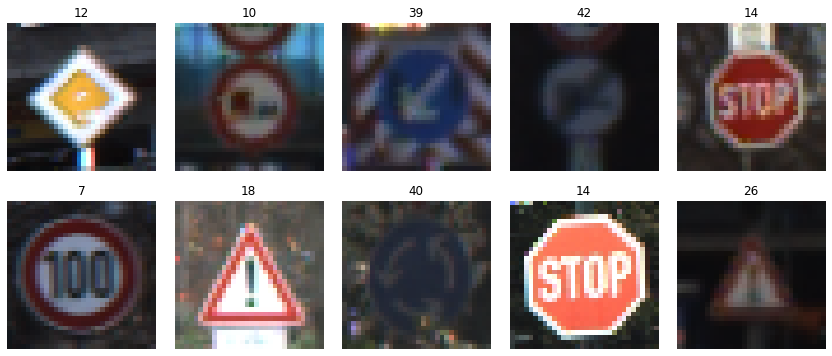

In [12]:
# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

Thus bar chart shows the frequency distribution of traffic sign respect to the classes.
This shows we are dealing with an imbalanced dataset - some classes are much more frequent than others.
This may be a problem

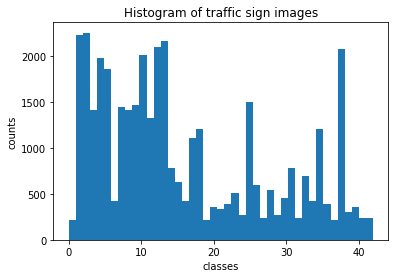

In [13]:
fig, ax = plt.subplots()
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of traffic sign images')
#p1 = ax.bar(ind,0,width,color='r',bottom=0,yerr=0)
plt.show()

----

## Step 2: Data Preparation




We first convert the images in greyscale so to simplify the problem. 

(39209, 32, 32, 3)
(39209, 32, 32)
(12630, 32, 32, 3)
(12630, 32, 32)


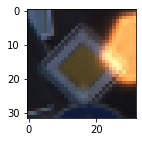

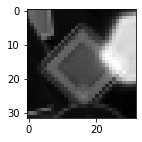

In [14]:
X_traingray = setgrayscale(X_train)
X_testgray = setgrayscale(X_test)


index = random.randint(0, len(X_traingray))

#orginal image
image = X_train[index]
plt.figure(figsize=(2,2))
plt.imshow(image)

#channel 0
#plt.figure(figsize=(2,2))
#plt.imshow(image[:,:,0])

#channel 1
#plt.figure(figsize=(2,2))
#plt.imshow(image[:,:,1])

#channel 2
#plt.figure(figsize=(2,2))
#plt.imshow(image[:,:,2])

#grayscale
image = X_traingray[index]
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")

The images have also been normalized to avoid numerical problems


We select only three classes and down-sample the dataset to reduce inference computational time.

In [16]:
np.random.seed(0)
classes = [1, 2, 4]
N_per_class =500
X = []
labels = []
for d in classes:
    imgs = X_traingray[np.where(y_train==d)[0],:]
    X.append(imgs[np.random.permutation(imgs.shape[0]),:][0:N_per_class,:])
    labels.append(np.ones(N_per_class)*d)
X_traingray2 = np.vstack(X).astype(np.float64)
y_train2 = np.hstack(labels)


In [17]:
print(X_traingray2.shape,y_train2.shape)

(1500, 32, 32) (1500,)


In [18]:
### we split tha dataset in training and validation
X_tr, X_val, y_tr, y_val = train_test_split(X_traingray2, y_train2, test_size=0.2, random_state=0)
 

X_tr, y_tr = shuffle(X_tr, y_tr)

print(X_tr.shape)
print(X_val.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 32, 32)
(300, 32, 32)
(1200,)
(300,)


In [73]:
X_tr.shape

(1200, 32, 32)

In [19]:
#we transform images into vectors  
X_trv = X_tr.flatten().reshape(X_tr.shape[0],X_tr.shape[1]*X_tr.shape[2])
X_valv = X_val.flatten().reshape(X_val.shape[0],X_tr.shape[1]*X_tr.shape[2])
print(X_trv.shape)
print(X_valv.shape)
print(y_tr.shape)
print(y_val.shape)

(1200, 1024)
(300, 1024)
(1200,)
(300,)


### Step 3: Algorithm
    
Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- data augmentation to increase the dataset.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

We are not interested in obtaining the highest performance, but more in understanding the various approaches.


We define our "general recipe" machine learning model: logistic regression

In [21]:
#General-recipe ML logistic regression
clf = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs',multi_class='multinomial').fit(X_trv, y_tr)
y_pred_logi = clf.predict(X_valv)
y_pred_logi_prob = clf.predict_proba(X_valv)
prob_classmax = np.max(y_pred_logi_prob,axis=1)
print("Accuracy=",accuracy_score(y_pred_logi,y_val))

Accuracy= 0.9166666666666666


In [22]:
np.sort(prob_classmax)

array([0.52463761, 0.53345139, 0.55643581, 0.55773802, 0.58224245,
       0.60403631, 0.61194201, 0.63821271, 0.64749601, 0.65715886,
       0.69360387, 0.69619205, 0.69694991, 0.73536481, 0.73689035,
       0.75177529, 0.76306229, 0.77138441, 0.78663479, 0.79221158,
       0.8356519 , 0.8422886 , 0.84329181, 0.85600026, 0.8604722 ,
       0.86107104, 0.88899516, 0.89406836, 0.89989458, 0.90122343,
       0.90539516, 0.91992252, 0.92262851, 0.92441869, 0.92695924,
       0.93359104, 0.93774265, 0.94308883, 0.94332458, 0.94498475,
       0.9458793 , 0.94839058, 0.95667568, 0.95716816, 0.95855322,
       0.96049391, 0.96328924, 0.96905102, 0.97063323, 0.97073504,
       0.97213351, 0.97267889, 0.97446643, 0.97453241, 0.97791746,
       0.97854603, 0.97964747, 0.98051971, 0.98125553, 0.98258478,
       0.98289948, 0.98434181, 0.98456661, 0.98485633, 0.98527569,
       0.98541942, 0.98621999, 0.98710027, 0.98790482, 0.98806405,
       0.98838859, 0.98885558, 0.9893193 , 0.98959645, 0.98998

In [23]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]

array([0.52463761, 0.98485633, 0.73689035, 0.73536481, 0.99990782,
       0.91992252, 0.88899516, 0.77138441, 0.99957861, 0.69619205,
       0.99999667, 0.95855322, 0.53345139, 0.98838859, 0.99667339,
       0.99212835, 0.97791746, 0.61194201, 0.63821271, 0.96049391,
       0.58224245, 0.99751282, 0.98959645, 0.93774265, 0.69360387])

In [24]:
np.array(y_pred_logi)

array([1., 1., 4., 1., 4., 4., 2., 1., 1., 4., 1., 4., 4., 1., 4., 1., 4.,
       4., 4., 4., 1., 1., 1., 1., 4., 2., 4., 2., 2., 4., 4., 1., 4., 2.,
       4., 4., 1., 2., 1., 1., 4., 4., 4., 2., 1., 2., 4., 2., 2., 4., 2.,
       4., 2., 4., 2., 4., 2., 2., 4., 4., 1., 1., 4., 1., 2., 2., 2., 4.,
       1., 4., 1., 1., 2., 4., 1., 2., 2., 1., 1., 4., 4., 1., 1., 1., 2.,
       1., 4., 1., 4., 1., 2., 1., 1., 1., 2., 4., 2., 1., 1., 2., 4., 4.,
       1., 2., 4., 2., 1., 1., 2., 4., 1., 1., 1., 1., 4., 2., 1., 4., 2.,
       1., 4., 2., 1., 2., 1., 2., 1., 1., 4., 2., 2., 2., 1., 4., 2., 1.,
       1., 1., 4., 1., 2., 2., 2., 4., 1., 1., 2., 1., 4., 1., 1., 4., 1.,
       2., 2., 2., 4., 1., 2., 2., 4., 2., 1., 4., 4., 2., 4., 4., 1., 1.,
       1., 4., 4., 1., 2., 1., 1., 2., 4., 2., 1., 1., 2., 1., 2., 1., 2.,
       1., 1., 1., 4., 4., 4., 1., 4., 1., 2., 1., 1., 1., 1., 1., 2., 1.,
       2., 2., 1., 1., 2., 2., 4., 2., 1., 4., 4., 1., 4., 2., 1., 4., 2.,
       1., 2., 2., 2., 1.

it performs quite well

## Step 4: Probabilistic ML

In [25]:
import sklearn.preprocessing
# we need to transfor classes into counts for that class, we will use LabelBinarizer
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_tr.reshape(-1,1))
nf = X_trv.shape[1]
nc = len(classes)

floatX = tt.config.floatX



init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)

with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    #we need to consider nc-1 features because the model is not identifiable
    #the softamx turns a vector into a probability that sums up to one
    #therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    #Likelihood
    mu = pm.math.matrix_dot(X_trv,β1) + α1
    p = tt.tensor.nnet.nnet.softmax(mu)# It doesn't work if the problem is binary
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

#We cannot use the categorical distribution because there is a bug




/home/benavoli/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [21]:
with multi_logistic:
    approx = pm.fit(300000, method='advi')

Average Loss = 10,716: 100%|██████████| 300000/300000 [18:46<00:00, 266.43it/s]
Finished [100%]: Average Loss = 10,712


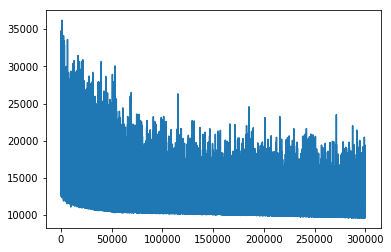

In [22]:
plt.plot(approx.hist)

In [23]:
posterior = approx.sample(draws=300)

true class= 4.0
estimated prob= [0.2347025  0.00000005 0.76529744]


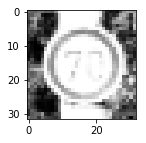

In [27]:
from scipy.special import softmax
i=10 #select an image in the test set
s=100 #select a sample in the posterior

beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_valv[i,:].reshape(32,32)
plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)
print("true class=",y_val[i])
print("estimated prob=",softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

In [28]:
# we return the class that has the highest posterior probability
y_pred_Bayesian=[]
for i in range(X_valv.shape[0]):
    val=np.zeros((1,len(classes)))
    for s in range(posterior['beta'].shape[0]):
        
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        
        val = val + softmax((np.array([X_valv[i,:].dot(beta) + alpha])))
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))


In [29]:
np.array(classes)[y_pred_Bayesian[0:10]]

array([1, 1, 4, 1, 4, 4, 2, 2, 1, 4])

In [30]:
print("Accuracy=",accuracy_score(np.array(classes)[y_pred_Bayesian],y_val))

Accuracy= 0.92


## Selecting different instances

In [31]:
y_predB=[]
for i in range(X_valv.shape[0]):
    #print(i)
    val=[]
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])
    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])
    
y_predB= np.array(y_predB)

In [40]:
y_predB[0:10,:]

array([[0.        , 0.86933776, 0.33259919],
       [0.        , 0.49986013, 0.49972215],
       [2.        , 0.6280445 , 0.48368952],
       [0.        , 0.79121501, 0.40491426],
       [2.        , 0.88989004, 0.15095989],
       [2.        , 0.91061395, 0.19595918],
       [1.        , 0.69984204, 0.4567883 ],
       [1.        , 0.57794782, 0.49056657],
       [0.        , 0.86992612, 0.33993463],
       [2.        , 0.99202914, 0.        ]])

In [50]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:10],:]

array([[1.        , 0.47565022, 0.49995555],
       [2.        , 0.5019077 , 0.49995555],
       [0.        , 0.51624215, 0.49989999],
       [0.        , 0.48920855, 0.49989999],
       [0.        , 0.49898607, 0.49989999],
       [2.        , 0.51970781, 0.49989999],
       [0.        , 0.49957717, 0.49982219],
       [1.        , 0.49515173, 0.49982219],
       [0.        , 0.48654376, 0.49982219],
       [0.        , 0.47263347, 0.49982219]])

In [54]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi!=y_val]

array([0.85661558, 0.98715747, 0.40006722, 0.99999998, 0.55664461,
       0.7549268 , 0.98064668, 0.99592836, 0.87686123, 0.67738354,
       0.95384876, 0.79993484, 0.99957193, 0.85859316, 0.63516454,
       0.99523409, 0.77912464, 0.99022744, 0.6853827 , 0.75006792,
       0.98677846, 0.99747082, 0.94091906, 0.95453669, 0.5023721 ])

In [55]:
y_predB[y_pred_logi!=y_val,:]

array([[2.        , 0.65514022, 0.47256981],
       [2.        , 0.56317347, 0.49355851],
       [0.        , 0.42226471, 0.49677851],
       [0.        , 0.64163718, 0.48095969],
       [1.        , 0.54368203, 0.49781746],
       [1.        , 0.74574318, 0.42503595],
       [1.        , 0.51565748, 0.49959984],
       [0.        , 0.56042159, 0.49243161],
       [2.        , 0.74587702, 0.4330127 ],
       [0.        , 0.51026748, 0.49959984],
       [0.        , 0.71616538, 0.44567053],
       [0.        , 0.47030082, 0.49972215],
       [0.        , 0.82386448, 0.37853519],
       [1.        , 0.47565022, 0.49995555],
       [2.        , 0.91075852, 0.22469733],
       [2.        , 0.38426065, 0.48774994],
       [2.        , 0.60367164, 0.48455019],
       [0.        , 0.47025416, 0.49909919],
       [0.        , 0.48920855, 0.49989999],
       [2.        , 0.5019077 , 0.49995555],
       [1.        , 0.65955034, 0.47021272],
       [2.        , 0.63646173, 0.48095969],
       [1.

In [41]:
easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =",accuracy_score(y_pred_logi[easy[0:100]],y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =",accuracy_score(y_pred_logi[difficult[0:100]],y_val[difficult[0:100]]))

Accuracy in easy instances = 1.0
Accuracy in difficult instances = 0.8


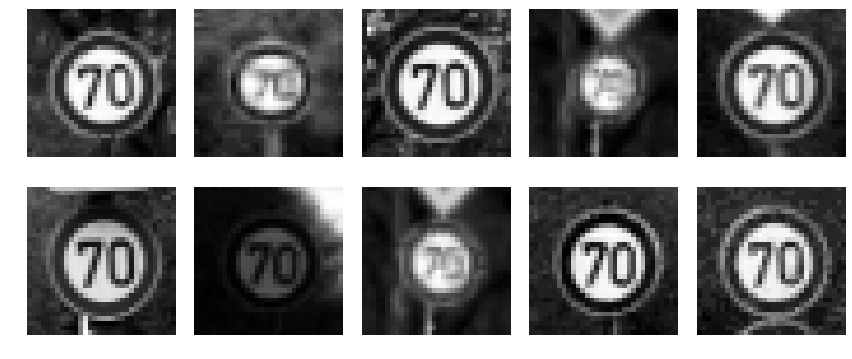

In [42]:

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = easy[i]
    image = X_valv[index,:].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

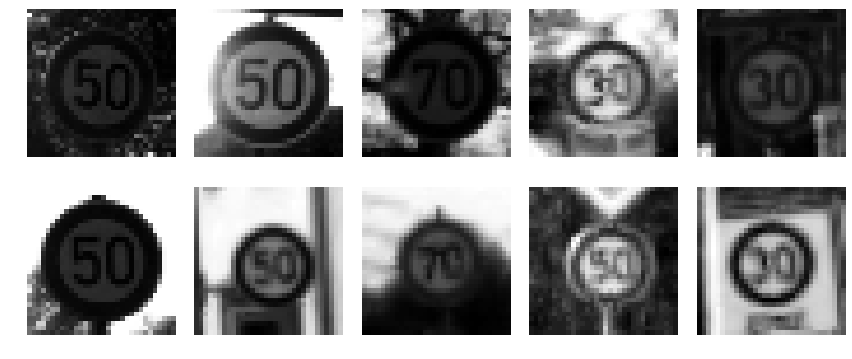

In [43]:

# show image of 10 random data points
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_valv[index,:].reshape(32,32)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    